<a href="https://colab.research.google.com/github/valid999/Implement_BatchNormalization_fromScratch/blob/main/Implement_Accelerating_Deep_Network_Training_b_y_Reducing_Internal_Covariate_Shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.distributions import uniform
import torch.optim as optim


import torchvision.transforms as transforms
import torchvision.datasets as datasets

import seaborn as sns
import matplotlib.pyplot as plt

## Explaining batch normalization

####  Defining Python dataset and loader

In [37]:
dataset =  datasets.MNIST(
    root = '../datasets',
    download = True ,
    train = True ,
    transform = transforms.ToTensor()
)

loader = DataLoader(
    dataset ,
    num_workers = 4 ,
    batch_size = 512 ,
    shuffle = True
)




In [38]:
class CustomBatchNorm(nn.Module):

  def __init__(self , in_size , momentum = 0.9 , eps = 1e-5):
    super(CustomBatchNorm , self).__init__()

    self.momentum = momentum
    self.insize = in_size
    self.eps = eps


    U = uniform.Uniform(torch.tensor([0.0]) , torch.tensor([1.0])) # Low & high
    self.gamma = nn.Parameter(U.sample(torch.Size([self.insize])).view(self.insize))
    self.beta = nn.Parameter(torch.zeros(self.insize))


    self.register_buffer('running_mean' , torch.zeros(self.insize)) # Normalize stage zero for the mean
    self.register_buffer('running_var' , torch.ones(self.insize)) # One for the variance


    self.running_mean.zero_()
    self.running_var.fill_(1)



  def forward(self , input): # Only supports batches

    X = input

    if len(X.shape)!= 2 : # One for batch second for the values
      raise ValueError('only support dense layers')

    if self.training:

      mean = torch.mean(X , axis = 0)
      variance = torch.mean((X-mean)**2 , axis = 0)

      self.running_mean = (self.momentum * self.running_mean) + (1.0-self.momentum) * mean # Meaning Multiply the current batch
      self.running_var = (self.momentum * self.running_var) + (1.0 - self.momentum) * (input.shape[0]/(input.shape[0]-1)*variance)



    else:
      mean = self.running_mean
      variance = self.running_var


    X_hat = (X - mean) * 1.0 / torch.sqrt(variance + self.eps)
    out = self.gamma * X_hat + self.beta

    return out






## Example neural net

In [39]:
class SimpleNet(nn.Module):
  def __init__(self):

    super(SimpleNet , self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(28 * 28 , 64),
        nn.ReLU(),
        nn.Linear(64 , 128),
        nn.ReLU(),
        nn.Linear(128 , 10)
    )
  def forward(self , x):
    x = x.view(x.size(0) , -1) # The Flatten layer
    x = self.classifier(x)
    return x

In [40]:
class SimpleNetBN(nn.Module):
    def __init__(self):
        super(SimpleNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            CustomBatchNorm(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            CustomBatchNorm(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Experiment with training with and without the batch Norm

In [41]:
net_without_batch_norm = SimpleNet()

In [42]:
net_with_batch_norm = SimpleNetBN()

In [43]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(net_without_batch_norm.parameters() , lr = 0.01)
opt_bn = optim.SGD(net_with_batch_norm.parameters() , lr = 0.01)


[1,   512] loss: 0.058  loss_bn: 0.058
[1, 20992] loss: 2.294  loss_bn: 2.074
[1, 41472] loss: 2.268  loss_bn: 1.687
[2,   512] loss: 0.055  loss_bn: 0.033
[2, 20992] loss: 2.177  loss_bn: 1.185
[2, 41472] loss: 2.081  loss_bn: 1.002
[3,   512] loss: 0.047  loss_bn: 0.021
[3, 20992] loss: 1.766  loss_bn: 0.771
[3, 41472] loss: 1.537  loss_bn: 0.678
[4,   512] loss: 0.030  loss_bn: 0.015
[4, 20992] loss: 1.089  loss_bn: 0.560
[4, 41472] loss: 0.932  loss_bn: 0.522
[5,   512] loss: 0.021  loss_bn: 0.012
[5, 20992] loss: 0.729  loss_bn: 0.457
[5, 41472] loss: 0.657  loss_bn: 0.427
[6,   512] loss: 0.015  loss_bn: 0.009
[6, 20992] loss: 0.569  loss_bn: 0.386
[6, 41472] loss: 0.547  loss_bn: 0.373
[7,   512] loss: 0.013  loss_bn: 0.009
[7, 20992] loss: 0.506  loss_bn: 0.347
[7, 41472] loss: 0.478  loss_bn: 0.334
[8,   512] loss: 0.011  loss_bn: 0.008
[8, 20992] loss: 0.449  loss_bn: 0.311
[8, 41472] loss: 0.447  loss_bn: 0.307
[9,   512] loss: 0.010  loss_bn: 0.007
[9, 20992] loss: 0.416  l

<ipython-input-44-000eeb818a53>:65: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a, kde=True, color='r', label='Normal')
<ipython-input-44-000eeb818a53>:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(b, kde=True, color='g', label='BatchNorm')


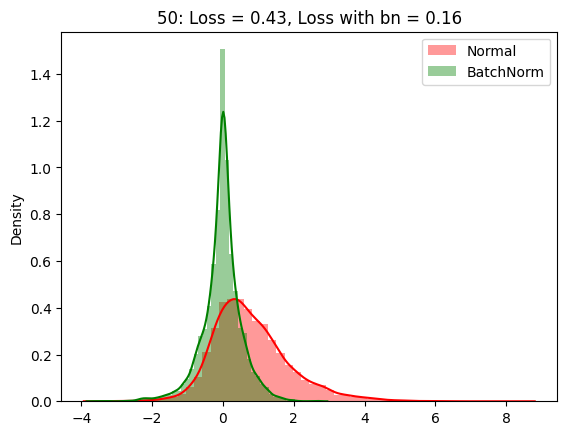

----------------------


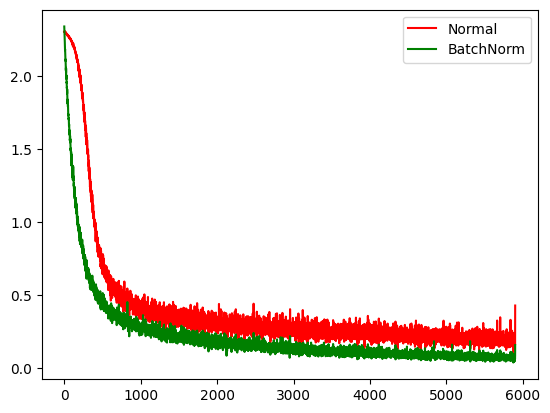

In [44]:
loss_arr = []
loss_bn_arr = []


max_epochs = 50


for epoch in range(max_epochs):

  running_loss = 0.0
  running_loss_bn = 0.0
  for i , data in enumerate(loader , 0):

    inputs , labels = data

    # Training steps for normal model

    opt.zero_grad()
    outputs = net_without_batch_norm(inputs)
    loss = loss_fn(outputs , labels)
    loss.backward()
    opt.step()


    # Training steps for batch normalization model
    opt.zero_grad()
    outputs = net_without_batch_norm(inputs)
    loss = loss_fn(outputs , labels)
    loss.backward()
    opt.step()



    # Training steps for the model
    opt_bn.zero_grad()
    outputs_bn = net_with_batch_norm(inputs)
    loss_bn = loss_fn(outputs_bn , labels)
    loss_bn.backward()
    opt_bn.step()

    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())


# print statistics
    running_loss += loss.item()
    running_loss_bn += loss_bn.item()
    if i % 40 == 0:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f  loss_bn: %.3f'%
              (epoch + 1, (i + 1)*512, running_loss / 40, running_loss_bn / 40))
        running_loss = 0.0
        running_loss_bn = 0.0
  print("="*40)


print("="*10 + " Epoch {} ".format(epoch+1) + "="*10)
inputs = inputs.view(inputs.size(0), -1)

# Code to get the activations
net_without_batch_norm.eval()
net_with_batch_norm.eval()

a = net_without_batch_norm.classifier[0](inputs)
a = a.detach().numpy().ravel()
sns.distplot(a, kde=True, color='r', label='Normal')

b = net_with_batch_norm.classifier[0](inputs)
b = net_with_batch_norm.classifier[1](b)
b = b.detach().numpy().ravel()
sns.distplot(b, kde=True, color='g', label='BatchNorm')

plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (epoch+1, loss.item(), loss_bn.item()))
plt.legend()
plt.savefig("activation-distribution.png", dpi=100)
plt.show()
plt.pause(0.5)

print('----------------------')

# Plotting the loss curves
plt.plot(loss_arr, 'r', label='Normal')
plt.plot(loss_bn_arr, 'g', label='BatchNorm')
plt.savefig("training-loss.png", dpi=100)
plt.legend()
plt.show()